In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [58]:
# Define constants
#IMAGE_DIR = "C:\\Users\\willi\\Documents\\Drexel\\Fall Quart 5\\MEM 679 - Machine Learning\\pokemon_images\\Pokemon_Dataset_Subset"
IMAGE_DIR = "C:\\Users\\willi\\Documents\\Drexel\\Fall Quart 5\\MEM 679 - Machine Learning\\pokemon_images\\Pokemon_Dataset_Full"
IMG_SIZE = (224, 224) #Images will be resized to 244 x 244
BATCH_SIZE = 32 #Number of images to process at a time

In [59]:
# Function to parse labels from filenames
def parse_filename(filename):
    """
    Parses the filename to extract metadata.

    Args:
        filename (str): The name of the image file.

    Returns:
        pokemon_name (str): Name of Pokemon
        shiny_form (int): 1 if Pokemon is shiny, 0 if Pokemon is Normal
        gender (str): Gender of Pokemon

    """
    parts = filename.replace('.png', '').split(' ')
    location_name = parts[0]
    shiny = 1 if 'Shiny' in parts else 0
    gender = 'Unknown'
    if 'Male & Female' in filename:
        gender = 'Male & Female'
    elif 'Male' in filename:
        gender = 'Male'
    elif 'Female' in filename:
        gender = 'Female'
    
    location, name = location_name.split('_', 1)
    
    return name, shiny, gender

In [60]:
# Load dataset
data = []
labels_name = []
labels_shiny = []
labels_gender = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith((".png")):
        filepath = os.path.join(IMAGE_DIR, file)
        name, shiny, gender = parse_filename(file)
        data.append(filepath)
        labels_name.append(name)
        labels_shiny.append(shiny)
        labels_gender.append(gender)

In [61]:
# Preprocess labels
unique_names = sorted(set(labels_name))
unique_genders = ["Male", "Female", "Male & Female"]

name_to_idx = {name: i for i, name in enumerate(unique_names)}
gender_to_idx = {gender: i for i, gender in enumerate(unique_genders)}

y_name = [name_to_idx[name] for name in labels_name]
y_shiny = labels_shiny
y_gender = [gender_to_idx[gender] for gender in labels_gender]

# Split data
train_data, val_data, train_labels, val_labels = train_test_split(
    data, list(zip(y_name, y_shiny, y_gender)), test_size=0.2, random_state=42
)

In [ ]:
# Preprocess images
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
def preprocess_images(filepaths, labels, batch_size):
    def generator():
        for filepath, label in zip(filepaths, labels):
            # Load the image
            image = tf.keras.utils.load_img(filepath)
            image = tf.keras.utils.img_to_array(image) / 255.0
            # Resize with padding
            image = tf.image.resize_with_pad(image, target_height=IMG_SIZE[0], target_width=IMG_SIZE[1])
            # Restructure labels into a dictionary for model outputs
            label_dict = {
                "name_output": label[0],
                "shiny_output": label[1],
                "gender_output": label[2]
            }
            yield image, label_dict
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
            {
                "name_output": tf.TensorSpec(shape=(), dtype=tf.int32),
                "shiny_output": tf.TensorSpec(shape=(), dtype=tf.int32),
                "gender_output": tf.TensorSpec(shape=(), dtype=tf.int32),
            },
        )
    ).batch(batch_size)

train_dataset = preprocess_images(train_data, train_labels, BATCH_SIZE)
val_dataset = preprocess_images(val_data, val_labels, BATCH_SIZE)

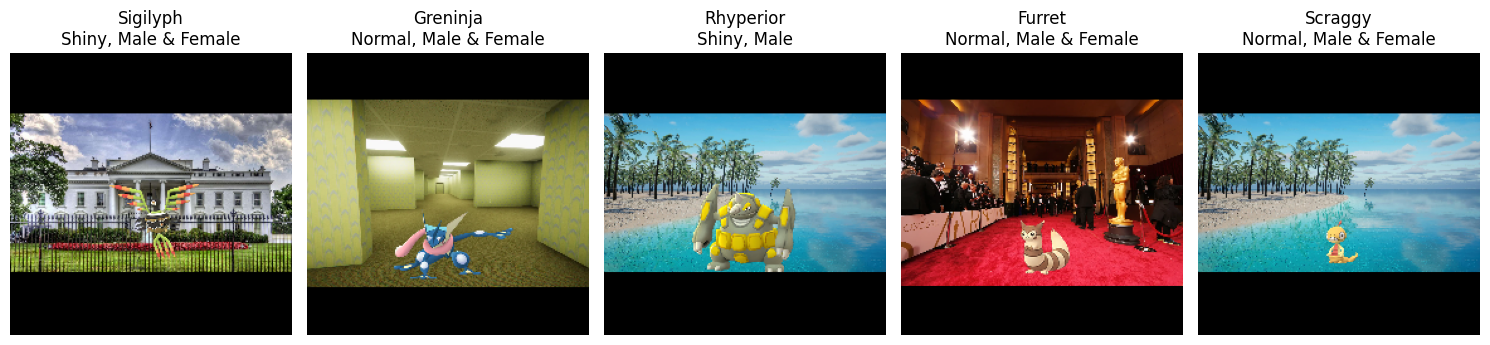

In [63]:
def visualize_preprocessed_images(dataset, num_images=5):
    """
    Visualizes a few random preprocessed images from the dataset.

    Args:
        dataset: A TensorFlow Dataset object containing preprocessed images and labels.
        num_images: Number of images to visualize.
    """
    plt.figure(figsize=(15, 5))
    for i, (image_batch, label_batch) in enumerate(dataset.take(1)):  # Take one batch from the dataset
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(image_batch[j].numpy())
            plt.axis('off')
            # Display the labels for the first image in the batch
            label = label_batch
            name = label["name_output"][j].numpy()
            shiny = "Shiny" if label["shiny_output"][j].numpy() == 1 else "Normal"
            gender = unique_genders[label["gender_output"][j].numpy()]
            plt.title(f"{unique_names[name]}\n{shiny}, {gender}")
        break  # Only process the first batch
    plt.tight_layout()
    plt.show()

visualize_preprocessed_images(train_dataset)

In [ ]:
# Build the model
base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3))
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)  # Existing dropout layer

# Add regularization to the Dense layers
name_output = Dense(len(unique_names), activation="softmax", name="name_output",
                    kernel_regularizer=l2(0.01))(x)
shiny_output = Dense(1, activation="sigmoid", name="shiny_output",
                     kernel_regularizer=l2(0.01))(x)
gender_output = Dense(len(unique_genders), activation="softmax", name="gender_output",
                      kernel_regularizer=l2(0.01))(x)

# Final model
model = Model(inputs=base_model.input, outputs=[name_output, shiny_output, gender_output])

# Compile the model
model.compile(
    optimizer="adam", 
    loss={
        "name_output": "sparse_categorical_crossentropy",
        "shiny_output": "binary_crossentropy",
        "gender_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "name_output": ["accuracy"],
        "shiny_output": ["accuracy"],
        "gender_output": ["accuracy"],
    }
)

In [ ]:
# Check available devices
physical_devices = tf.config.list_physical_devices()
for device in physical_devices:
    print(device)

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used.")
else:
    print("GPU not available, using CPU.")

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
GPU not available, using CPU.


In [ ]:
# Train the model
model.compile(
    optimizer="adam",
    loss={
        "name_output": "sparse_categorical_crossentropy",
        "shiny_output": "binary_crossentropy",
        "gender_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "name_output": ["accuracy"],
        "shiny_output": ["accuracy"],
        "gender_output": ["accuracy"],
    }
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000002910FF3F2E0>
Traceback (most recent call last):
  File "c:\Users\willi\Anaconda3\envs\PokemonIdentifier\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
# Save the model
#model.save("pokemon_classifier.h5") 